# Introduction to Data Science 
# Lecture 13: Classification 1
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecutre, we'll discuss:
* a general overview of classification 
* logistic regression 
* k nearest neighbors (k-NN) 
* generalizability and cross validation 

Recommended Reading: 
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 4 [digitial version available here](http://www-bcf.usc.edu/~gareth/ISL/)
* J. Grus, Data Science from Scratch, Ch.12,16

In [1]:
# imports and setup

import scipy as sc
import pandas as pd
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Classification 

Recall that in **regression**, we try to predict a real-valued (quantitative) variable. Examples:
1. Predict house prices based on attributes
+ predict credit score rating based on income, balance, gender, education, etc...


In ** classification**, we try to predict a categorical (qualitative) variable. Examples:
1. Predict whether a bank should issue a person a credit card (yes/no)
+ Predict a hospital patient's diagnosis (stroke, heart attack,...) based on symptoms. 

**Setup:** Given $n$ samples $(x_1,y_1), (x_2,y_2),\ldots,(x_n,y_n)$, where $x_i$ are attributes or features and $y_i$ are categorical variables that you want to predict. 

**Goal:** Develop a rule for predicting the categorical variable $y$ based on the features $x$. 

**Example:** Can the number of hours a student studies predict whether they will pass the exam?

**Example:** Can we predict whether or not a student will be admitted to a graduate program based on their undergraduate performance (GPA, GRE score, prestige of student's undergraduate university)? 

**Example:** The post office uses classification to automatically sort mail by zip code. The digits of the zip code are assigned to one of the *classes:* $0,1,2,\ldots,9$. 

Today and on Thursday, we'll cover several classification methods:
* logistic regression
+ k nearest neighbors
+ trees and random forests
+ support vector machines

After spring break, we'll cover yet another method:
* Neural Networks and Deep Learning

** Evaluation:** How can we evaluate how well a classification algorithm has done? One way is via the confusion matrix. The *confusion matrix* is just a table where each column of the matrix represents the number of samples in each predicted class and each row represents the number of samples in each actual class. 

Consider the results from a classifier that is trying to classify 27 images of cats, dogs, and rabbits.
<img src="ConfusionMatrix.png", title="https://en.wikipedia.org/wiki/Confusion_matrix", width="40%">

This classifier is very good at distinguishing between cats and rabbits but lousy at recognizing dogs...half are misclassified!


## Logistic regression 

In logistic regression, the categorical value, $Y$, that we predict only takes two values. We'll call them 0 and 1. 

**Main idea:** Given the predictor variable  X, we model the *probability* that $Y = 1$ by 
$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\beta_0 + \beta_1 X}}{1+ e^{\beta_0 + \beta_1 X}}
$$

Defining the *logistic function* or *sigmoid function*,  
$$
\textrm{logistic}(x) := \frac{e^x}{1 + e^x} = \frac{1}{1+ e^{-x}},
$$
we can write the above expression more succinctly as 
$$
p(X) = \textrm{logistic}( \beta_0 + \beta_1 X ).  
$$

One can check that the model is equivlant to 
$$
\log \left( \frac{p(X)}{1-p(X)} \right) = \beta_0 + \beta_1 X. 
$$

Sometimes, the function on the left hand side of the above equation is called the *logit function*, 
$$
\textrm{logit}(p) := \log \left( \frac{p}{1-p} \right). 
$$
We can equivalently write the model as 

$$
\textrm{logit} ( p(X) ) = \beta_0 + \beta_1 X.  
$$
It follows that the logistic and logit functions are inverses of each other. 

We interpret $\frac{p(X)}{1-p(X)}$ as being the *odds* that $Y=1$. Note that $p(X)$ is a number between 0 and 1 so that the odds that $Y=1$ is a number between 0 and $\infty$. If $p(X) = 0.5$, then odds = 1.  We also have that $\textrm{logit} ( p(X) )$ is a number between $-\infty$ and $\infty$, so it makes sense that it could be linear in the data (as modeled). 


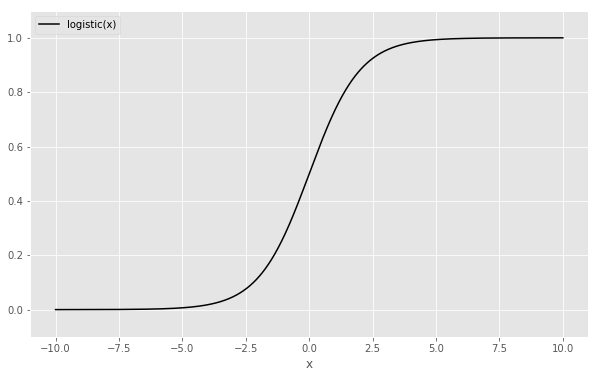

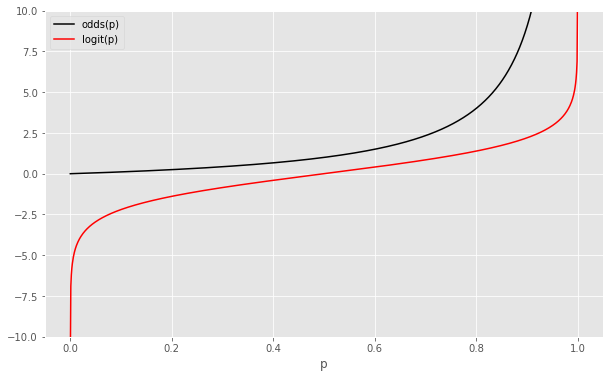

In [2]:
x = sc.linspace(-10,10,1000)
logistic = lambda x: 1/(1+sc.exp(-x))
plt.plot(x,logistic(x),color='black',label='logistic(x)')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylim(-.1,1.1)
plt.show()

p = sc.linspace(1e-5,1-1e-5,1000)
odds = lambda p: p/(1-p)
logit = lambda p: sc.log(odds(p))
plt.plot(p,odds(p),color='black',label='odds(p)')
plt.plot(p,logit(p),color='red',label='logit(p)')
plt.legend(loc='upper left')
plt.xlabel('p')
plt.ylim(-10,10)
plt.show()

**Logistic regression:** Given samples $(x_i,y_i)$ for $i=1,\ldots,n$, find the *best* values of $\beta_0$ and $\beta_1$ so that 
$$
y = \textrm{logistic}( \beta_0 + \beta_1 X ) 
\qquad \textrm{or} \qquad
\textrm{logit} ( y ) = \beta_0 + \beta_1 X.  
$$
Recall that in linear regression, we found the the coefficients $\beta_0$ and $\beta_1$ by setting up the sum of the squared residuals $\sum_{i} (y_i - \beta_0 - \beta_1 x_i)^2$, setting the partial derivatives with respect to  $\beta_0$ and $\beta_1$ to zero, and solving for  $\hat \beta_0$ and $\hat \beta_1$. 
We can try to do the same thing here, but unlike linear regression, there is no longer a closed form solution for the best coefficients $\hat \beta_0$ and $\hat \beta_1$. We have to use a computer to find them. 

**Statistical inference viewpoint:** 
Above, logistic regression was described from the explanatory viewpoint of finding the best parameters to describe the data. 
Just like as in regression, there is also a statistical inference viewpoint. The categorical variable is modeled as 
$$
y = \begin{cases}
1 &  \beta_0 + \beta_1 x + \epsilon > 0 \\
0 & \text{otherwise}
\end{cases}
$$
where $\epsilon$ is a random variable that is distributed according to the logistic distribution. Here, we seek to infer the values of $\beta_0$ and $\beta_1$ from noisy samples of this variable. 

## Logistic Regression Example:  How many hours do you need to study to pass the exam? 

This example was taken from [wikipedia](https://en.wikipedia.org/wiki/Logistic_regression). 

In [3]:
hours = [0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50] 
pass_Exam = [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
df = pd.DataFrame({"hours": hours, "pass_exam": pass_Exam})
df

,hours,pass_exam
0,0.50,0
1,0.75,0
2,1.00,0
3,1.25,0
4,1.50,0
5,1.75,0
6,1.75,1
7,2.00,0
8,2.25,1
9,2.50,0


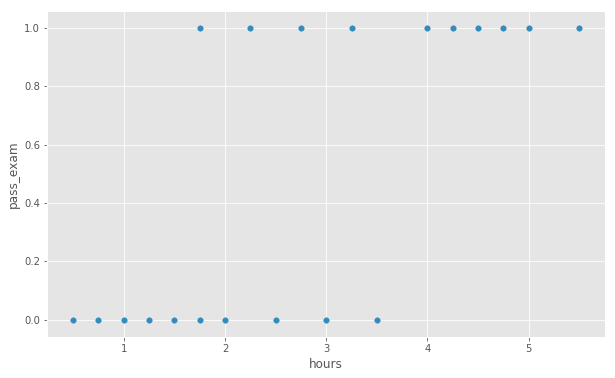

In [4]:
df.plot.scatter(x='hours',y='pass_exam',s=30);

For this example, we want to find coefficients $\beta_0$ and $\beta_1$ so that the model
$$
p(X) = \textrm{probability}(\textrm{passing} | \ \textrm{X hours studying} ) = \textrm{logistic}( \beta_0 + \beta_1 X )
$$
best explains the data. 

We can use the 'logit' function from the statsmodels python library. 

In [5]:
exam_model = sm.logit(formula="pass_Exam ~ hours", data=df).fit()
exam_model.summary()

Optimization terminated successfully.
         Current function value: 0.401494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              pass_Exam   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:                  0.4208
Time:                        10:09:01   Log-Likelihood:                -8.0299
converged:                       True   LL-Null:                       -13.863
                                        LLR p-value:                 0.0006365
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0777      1.761     -2.316      0.021      -7.529      -0.626
hours          1.5046      0.629      2.393      0.017       0.272       2.737
==============================================================================
"""

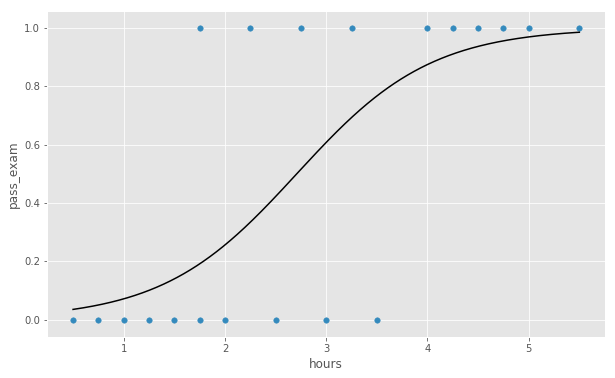

In [6]:
df.plot.scatter(x='hours',y='pass_exam',s=30)
x = sc.linspace(df['hours'].min(),df['hours'].max(),1000)
par = dict(exam_model.params)
plt.plot(x,logistic(par['Intercept'] + par['hours']*x),color='Black')
plt.show()

The plot shows hours vs. whether or not the student passed and the logistic regression curve. The curve predicts the probability that a student will pass, given how many hours they've studied. 

From the plot, we can see that the more hours you spend studying, the more likely you are to pass the exam. *Let this be a lesson!* 

If I study just 2 hours, what is the likelihood that I'll pass? 

In [7]:
logistic(par['Intercept'] + par['hours']*2)

0.25570318264090985

I can also get this from exam_model:

In [8]:
exam_model.predict(pd.DataFrame({"hours": [2]}))

0    0.255703
dtype: float64

After studying just 2 hours, I'm only $26\%$ likely to pass. 

How many hours do you have to study in order for the probability of passing to be greater than $50\%$?

From the plot, it looks like $\approx 2.75$ hours. How can we find this number from the logistic regression? 

Recall: 
$$
p(X) = \textrm{logistic}( \beta_0 + \beta_1 X ).  
$$

In [9]:
prob_passing = 0.5
print((logit(prob_passing) - par['Intercept'])/par['hours'])

2.71008262425


We can also make a confusion matrix for the model: 

In [10]:
df['pred_pass'] = exam_model.predict()>.5
pd.crosstab(index=df["pass_exam"], columns=df["pred_pass"]) # confusion matrix

pred_pass,False,True
pass_exam,,
0,8,2
1,2,8


We interpret this as: for each category (pass,fail), there were two mistakenly classified points. 

## Logistic Regression Example: Graduate school admission based on undergraduate performance 

This example is based on [this blog post](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html). 


**Dataset:**: For 400 students, we have the students attributes: GRE score, GPA, and the "prestige" of the student's undergraduate university (scale of 1 to 4, 1 best). We also have the variable that we want to predict: will they be accepted to grad school (yes/no)? 


In [11]:
df = pd.read_csv("binary.csv")

# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.columns = ["admit", "gre", "gpa", "prestige"]

#there are 400 students with 4 attributes: admit, gre, gpa, prestige
print(df.shape)
df.head()

(400, 4)


,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [12]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


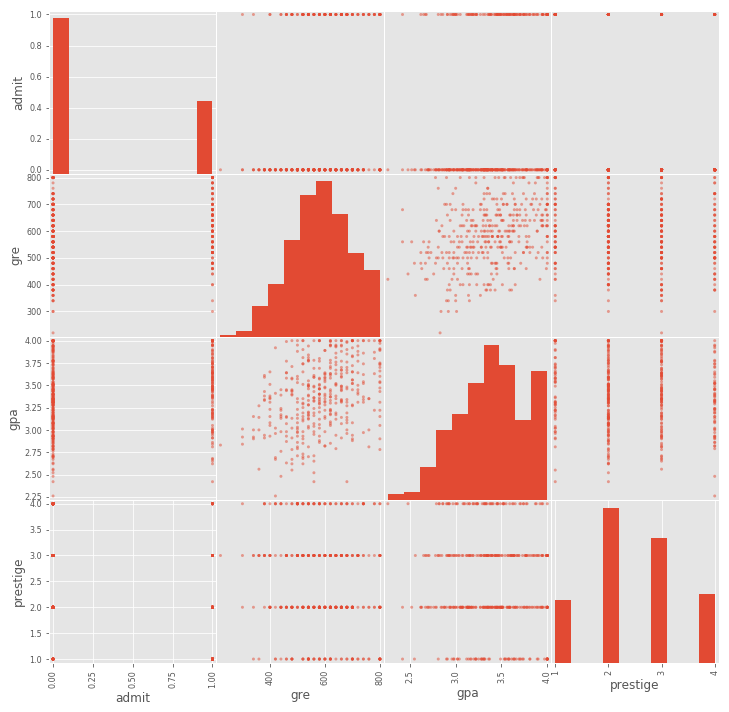

In [13]:
pd.plotting.scatter_matrix(df,figsize=(12, 12), diagonal='hist'); 

### A first attempt at logistic regression
Let's first just focus on the GRE score. Our model is 
$$
\textrm{logit} ( \textrm{probability admittance} ) = \beta_0 + \beta_1 * \textrm{GRE}.  
$$

In [14]:
grad_model = sm.logit(formula="admit ~ gre", data=df).fit()
grad_model.summary()

Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      398
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:                 0.02784
Time:                        10:09:04   Log-Likelihood:                -243.03
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 0.0001907
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9013      0.606     -4.787      0.000      -4.089      -1.714
gre            0.0036      0.001      3.633      0.000       0.002       0.006
==============================================================================
"""

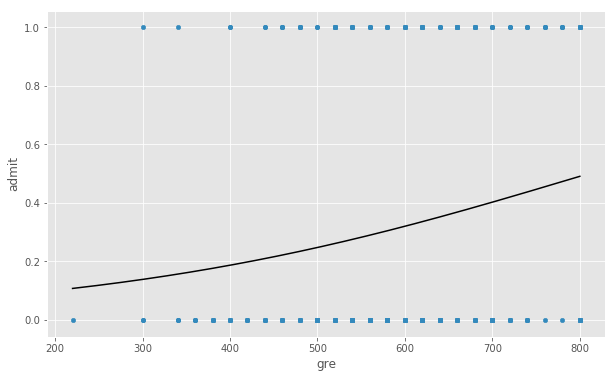

In [15]:
df.plot.scatter(x='gre',y='admit')

x = sc.linspace(df['gre'].min(),df['gre'].max(),1000)
par = dict(grad_model.params)
plt.plot(x,logistic(par['Intercept'] + par['gre']*x),color='Black');

In [16]:
df['pred_admit_1'] = grad_model.predict()>.5 
print(pd.crosstab(index=df["admit"], columns=df["pred_admit_1"]))

pred_admit_1  False
admit              
0               273
1               127


With only the GRE score, we basically just predict that everyone's probability of being admitted to graduate school $< 50\%$.  This is reflected in the confusion matrix. 

We need to include more data into our model! 

### A second attempt at logistic regression

Include both GPA and GRE scores. Our model is 
$$
\textrm{logit} ( \textrm{probability admittance} ) = \beta_0 + \beta_1 * \textrm{GRE} + \beta_2 * \textrm{GPA} .  
$$

In [17]:
grad_model = sm.logit(formula="admit ~ gre + gpa", data=df).fit()
grad_model.summary()

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:                 0.03927
Time:                        10:09:04   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9494      1.075     -4.604      0.000      -7.057      -2.842
gre            0.0027      0.001      2.544      0.011       0.001       0.005
gpa            0.7547      0.320      2.361      0.018       0.128       1.381
==============================================================================
"""

In [18]:
df['pred_admit_2'] = grad_model.predict()>.5
pd.crosstab(index=df["admit"], columns=df["pred_admit_2"]) # confusion matrix

pred_admit_2,False,True
admit,,
0,263,10
1,118,9


We're still predicting that most students are not being admitted - still not a very good model. This isn't so surprising if we look at a plot of GPA vs. GRE and try to see which students are admitted. You can't tell with your eye, so it's not surprising that the model fails too. (This is generally a good check.) 

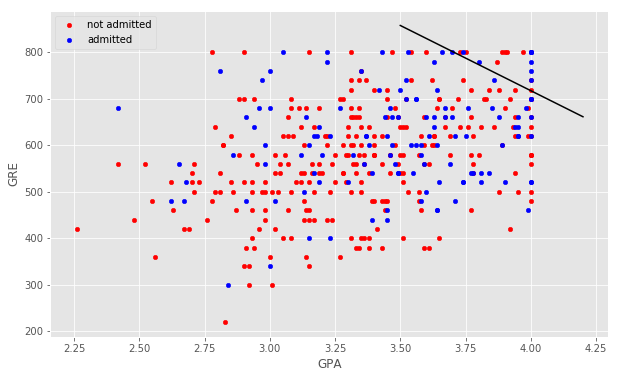

In [19]:
ax = df[df['admit']==0].plot.scatter(x='gpa',y='gre',color='red',label='not admitted')
df[df['admit']==1].plot.scatter(x='gpa',y='gre',color='blue',label='admitted', ax=ax)

x = sc.linspace(3.5,4.2,1000)
par = dict(grad_model.params)
plt.plot(x,(1/par['gre'])*(logit(.5) - par['Intercept'] - par['gpa']*x),color='Black')

plt.xlabel('GPA')
plt.ylabel('GRE')
plt.legend(loc='upper left')
plt.show()

### A third attempt

Finally, we include the 'prestige' of the school as a predictor variable.

To get an idea of how many students are admitted from schools of different prestige, we can use the *crosstab* function in the pandas library. 

In [20]:
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


We see that a smaller percentage of students are admitted from less prestigious universities. 

Recall that in linear regression, you can regress on ordinal variables by creating *dummy* variables (except baseline variable). We did this for the ethnicity variable in the credit dataset. One can similarly consider the prestige variable to be an ordinal variable and create a dummy variables...this is done [here](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html) if you want to read about it. 

I found that the results are not much worse (and simpler) if we consider prestige to be an interval variable (equal increments between prestige levels). 

In [21]:
grad_model = sm.logit(formula="admit ~ gre + gpa + prestige", data=df).fit()
grad_model.summary()

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:                 0.08107
Time:                        10:09:05   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 8.207e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
gre            0.0023      0.001      2.101      0.036       0.000       0.004
gpa            0.7770      0.327      2.373      0.018       0.135       1.419
prestige      -0.5600      0.127     -4.405      0.000      -0.809      -0.311
==============================================================================
"""

In [22]:
df['pred_admit_3'] = grad_model.predict()>.5
pd.crosstab(index=df["admit"], columns=df["pred_admit_3"]) # confusion matrix

pred_admit_3,False,True
admit,,
0,253,20
1,98,29


We're still now correctly predicting ($253/273=92\%$)  of the students who are not admitted. However, we're only correctly predicting ($29/127 = 23\%$) of the students who are admitted. 

**Moral:** GRE, gpa, and 'prestige' alone do not predict admittance to graduate school. 

